In [2]:
########################
import pandas as pd  
import numpy as np
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 
from pylab import rcParams
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
##############################################
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

df = pd.read_csv('D:/Credit Card Fraud Detection/creditcard.csv')
df.isnull().values.any()
Fdf = df[df.Class == 1 ]
Ndf = df[df.Class == 0 ]
transactions = df.drop(['Time'],axis = 1)
transactions.Amount = StandardScaler().fit_transform(transactions.Amount.values.reshape(-1,1))
X_train, X_test = train_test_split(transactions, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values
##################################

epoch [1/100], loss:0.8428
epoch [2/100], loss:0.7721
epoch [3/100], loss:0.7370
epoch [4/100], loss:0.7269
epoch [5/100], loss:0.7235
epoch [6/100], loss:0.7211
epoch [7/100], loss:0.7194
epoch [8/100], loss:0.7180
epoch [9/100], loss:0.7160
epoch [10/100], loss:0.7152
epoch [11/100], loss:0.7149
epoch [12/100], loss:0.7144
epoch [13/100], loss:0.7138
epoch [14/100], loss:0.7136
epoch [15/100], loss:0.7136
epoch [16/100], loss:0.7130
epoch [17/100], loss:0.7127
epoch [18/100], loss:0.7124
epoch [19/100], loss:0.7123
epoch [20/100], loss:0.7122
epoch [21/100], loss:0.7118
epoch [22/100], loss:0.7115
epoch [23/100], loss:0.7116
epoch [24/100], loss:0.7114
epoch [25/100], loss:0.7112
epoch [26/100], loss:0.7111
epoch [27/100], loss:0.7110
epoch [28/100], loss:0.7107
epoch [29/100], loss:0.7103
epoch [30/100], loss:0.7103
epoch [31/100], loss:0.7102
epoch [32/100], loss:0.7101
epoch [33/100], loss:0.7098
epoch [34/100], loss:0.7101
epoch [35/100], loss:0.7100
epoch [36/100], loss:0.7099
e

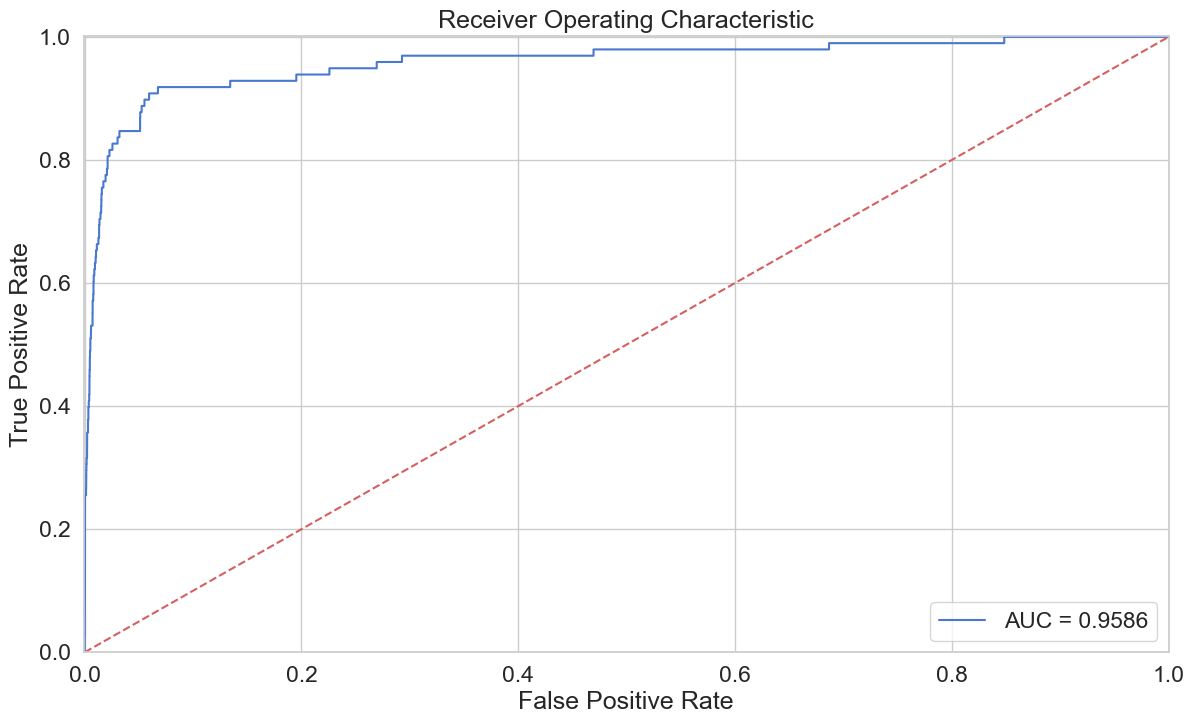

Card Precision at k=100: 0.26


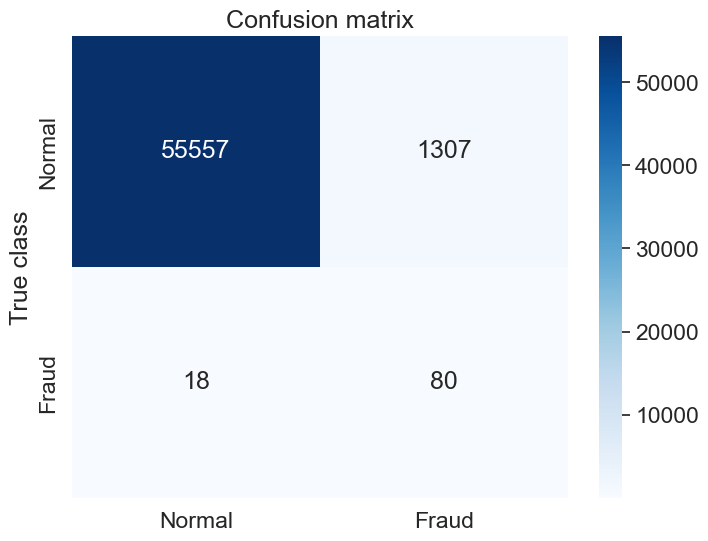

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29,14),
            nn.Tanh(),
            nn.Linear(14,7),
            nn.ReLU(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 7),
            nn.Tanh(),
            nn.Linear(7, 29),
            nn.ReLU()
            )
    def forward(self , x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

model = Autoencoder().double().cpu()
num_epochs = 100
minibach_size = 32
lr = 1e-3
train_loader = data_utils.DataLoader(X_train,batch_size=minibach_size,shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=lr, weight_decay=10e-05)
history = {}
history['train_loss'] = []
history['test_loss'] = []
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)
 

pred_losses = { 'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

threshold = 2.9
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]

conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap='Blues')  # Use 'Blues' directly
plt.title("Confusion matrix")
plt.ylabel('True class')
from sklearn.metrics import precision_score, roc_curve, auc
def card_precision_at_k(pred_scores, true_labels, k=100):
    # Sort predictions by scores in descending order
    sorted_indices = np.argsort(pred_scores)[::-1]
    # Get top k indices
    top_k_indices = sorted_indices[:k]
    # Get corresponding true labels
    top_k_labels = true_labels[top_k_indices]
    # Calculate precision for top k
    precision = precision_score(top_k_labels, np.ones(k))  # assuming 1 is the positive class
    return precision
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

# Calculate card precision at k
pred_scores = reconstructionErrorDF['pred_loss'].values
k = 100
card_precision = card_precision_at_k(pred_scores, y_test, k=k)
print(f"Card Precision at k={k}: {card_precision}")

In [5]:
class GEU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(0.5))  # 1个可学习参数 sigma

    def forward(self, input):
        # 计算 GEU 激活函数的输出
        temp = torch.tanh(input / self.sigma)
        return temp

class GELU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(0.8))  # 1个可学习参数 sigma

    def forward(self, input):
        # GELU 激活函数的计算公式
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29,14),
            GEU(),
            nn.Linear(14,7),
            GELU(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 7),
            GEU(),
            nn.Linear(7, 29),
            GELU()
            )
    def forward(self , x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

model = Autoencoder().double().cpu()
num_epochs = 100
minibach_size = 32
lr = 1e-3
train_loader = data_utils.DataLoader(X_train,batch_size=minibach_size,shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=lr, weight_decay=10e-05)
history = {}
history['train_loss'] = []
history['test_loss'] = []
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)
 

epoch [1/100], loss:0.7003
epoch [2/100], loss:0.5980
epoch [3/100], loss:0.5782
epoch [4/100], loss:0.5698
epoch [5/100], loss:0.5638
epoch [6/100], loss:0.5593
epoch [7/100], loss:0.5576
epoch [8/100], loss:0.5564
epoch [9/100], loss:0.5556
epoch [10/100], loss:0.5551
epoch [11/100], loss:0.5544
epoch [12/100], loss:0.5538
epoch [13/100], loss:0.5532
epoch [14/100], loss:0.5528
epoch [15/100], loss:0.5522
epoch [16/100], loss:0.5517
epoch [17/100], loss:0.5513
epoch [18/100], loss:0.5512
epoch [19/100], loss:0.5509
epoch [20/100], loss:0.5508
epoch [21/100], loss:0.5508
epoch [22/100], loss:0.5505
epoch [23/100], loss:0.5506
epoch [24/100], loss:0.5505
epoch [25/100], loss:0.5502
epoch [26/100], loss:0.5502
epoch [27/100], loss:0.5501
epoch [28/100], loss:0.5501
epoch [29/100], loss:0.5498
epoch [30/100], loss:0.5502
epoch [31/100], loss:0.5498
epoch [32/100], loss:0.5497
epoch [33/100], loss:0.5500
epoch [34/100], loss:0.5499
epoch [35/100], loss:0.5499
epoch [36/100], loss:0.5500
e

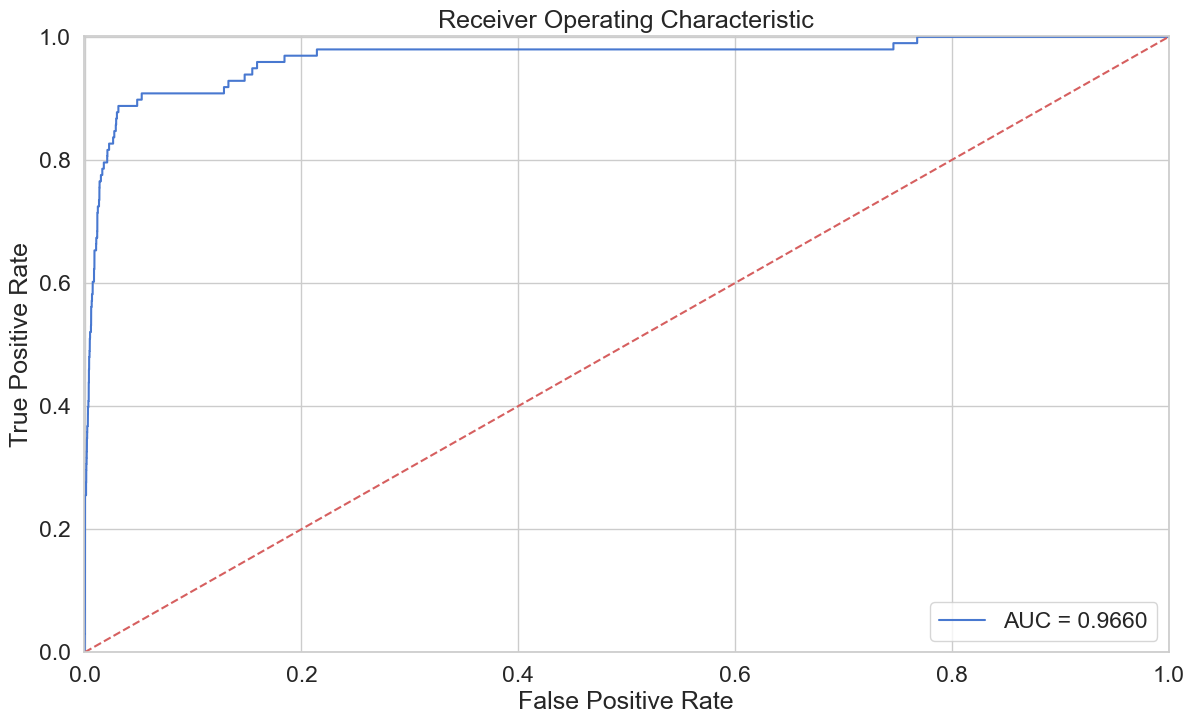

Card Precision at k=100: 0.27


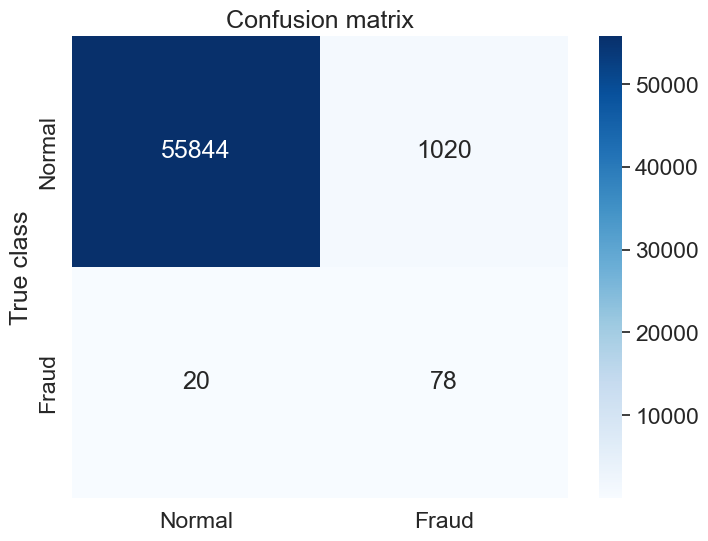

In [6]:
#######GEU+GELU
pred_losses = { 'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

threshold = 2.9
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]

conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap='Blues')  # Use 'Blues' directly
plt.title("Confusion matrix")
plt.ylabel('True class')
from sklearn.metrics import precision_score, roc_curve, auc
def card_precision_at_k(pred_scores, true_labels, k=100):
    # Sort predictions by scores in descending order
    sorted_indices = np.argsort(pred_scores)[::-1]
    # Get top k indices
    top_k_indices = sorted_indices[:k]
    # Get corresponding true labels
    top_k_labels = true_labels[top_k_indices]
    # Calculate precision for top k
    precision = precision_score(top_k_labels, np.ones(k))  # assuming 1 is the positive class
    return precision
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

# Calculate card precision at k
pred_scores = reconstructionErrorDF['pred_loss'].values
k = 100
card_precision = card_precision_at_k(pred_scores, y_test, k=k)
print(f"Card Precision at k={k}: {card_precision}")

epoch [1/100], loss:0.6837
epoch [2/100], loss:0.5881
epoch [3/100], loss:0.5728
epoch [4/100], loss:0.5661
epoch [5/100], loss:0.5629
epoch [6/100], loss:0.5611
epoch [7/100], loss:0.5593
epoch [8/100], loss:0.5579
epoch [9/100], loss:0.5567
epoch [10/100], loss:0.5562
epoch [11/100], loss:0.5559
epoch [12/100], loss:0.5552
epoch [13/100], loss:0.5548
epoch [14/100], loss:0.5544
epoch [15/100], loss:0.5539
epoch [16/100], loss:0.5532
epoch [17/100], loss:0.5522
epoch [18/100], loss:0.5513
epoch [19/100], loss:0.5501
epoch [20/100], loss:0.5493
epoch [21/100], loss:0.5484
epoch [22/100], loss:0.5473
epoch [23/100], loss:0.5471
epoch [24/100], loss:0.5469
epoch [25/100], loss:0.5461
epoch [26/100], loss:0.5459
epoch [27/100], loss:0.5455
epoch [28/100], loss:0.5452
epoch [29/100], loss:0.5448
epoch [30/100], loss:0.5451
epoch [31/100], loss:0.5447
epoch [32/100], loss:0.5445
epoch [33/100], loss:0.5448
epoch [34/100], loss:0.5447
epoch [35/100], loss:0.5445
epoch [36/100], loss:0.5444
e

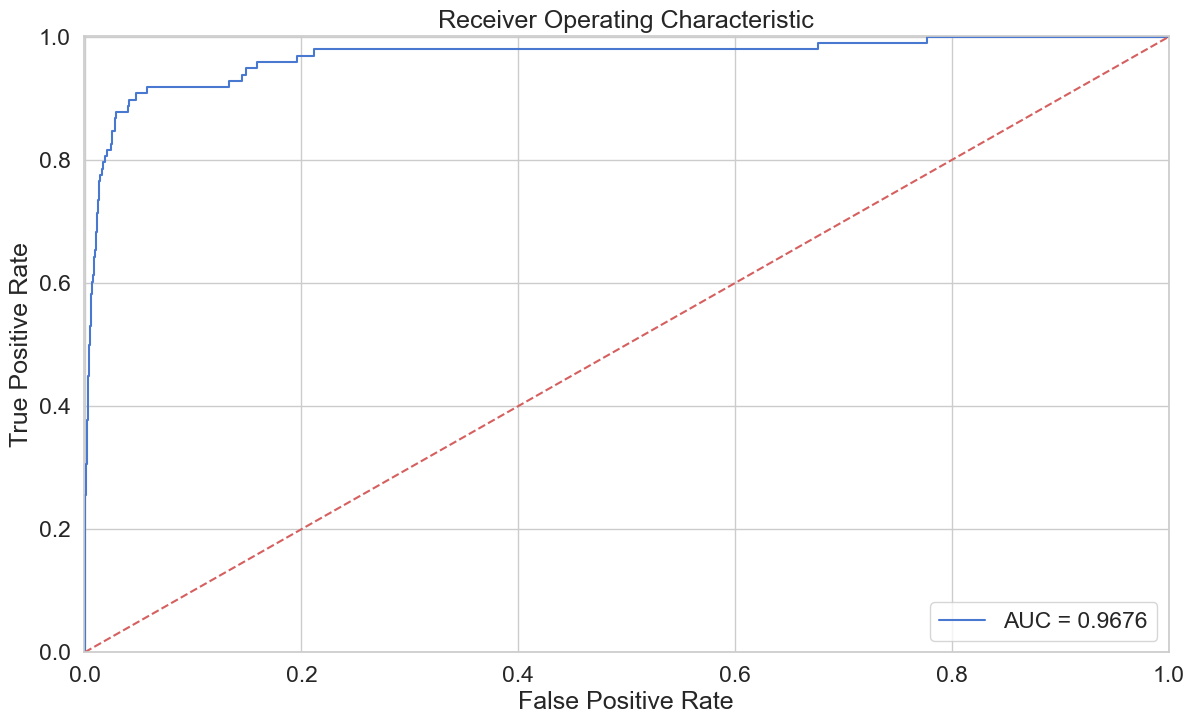

Card Precision at k=100: 0.27


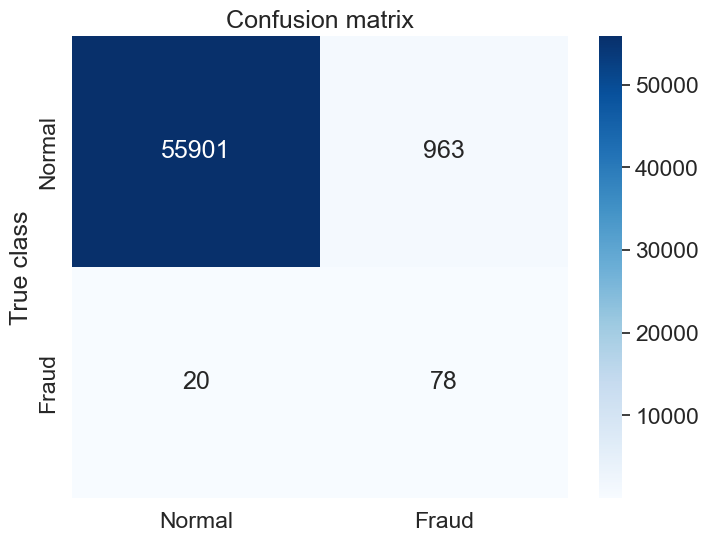

In [2]:
class GEU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 1个可学习参数 sigma

    def forward(self, input):
        # 计算 GEU 激活函数的输出
        temp = torch.tanh(input / self.sigma)
        return temp

class SiLU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 1个可学习参数 sigma

    def forward(self, input):
        # GELU 激活函数的计算公式
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = input * torch.sigmoid(input /self.sigma)
        return temp

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29,14),
            GEU(),
            nn.Linear(14,7),
            SiLU(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 7),
            GEU(),
            nn.Linear(7, 29),
            SiLU()
            )
    def forward(self , x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

model = Autoencoder().double().cpu()
num_epochs = 100
minibach_size = 32
lr = 1e-3
train_loader = data_utils.DataLoader(X_train,batch_size=minibach_size,shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=lr, weight_decay=10e-05)
history = {}
history['train_loss'] = []
history['test_loss'] = []
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)

pred_losses = { 'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

threshold = 2.9
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]

conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap='Blues')  # Use 'Blues' directly
plt.title("Confusion matrix")
plt.ylabel('True class')
from sklearn.metrics import precision_score, roc_curve, auc
def card_precision_at_k(pred_scores, true_labels, k=100):
    # Sort predictions by scores in descending order
    sorted_indices = np.argsort(pred_scores)[::-1]
    # Get top k indices
    top_k_indices = sorted_indices[:k]
    # Get corresponding true labels
    top_k_labels = true_labels[top_k_indices]
    # Calculate precision for top k
    precision = precision_score(top_k_labels, np.ones(k))  # assuming 1 is the positive class
    return precision
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

# Calculate card precision at k
pred_scores = reconstructionErrorDF['pred_loss'].values
k = 100
card_precision = card_precision_at_k(pred_scores, y_test, k=k)
print(f"Card Precision at k={k}: {card_precision}")

epoch [1/100], loss:0.6427
epoch [2/100], loss:0.5653
epoch [3/100], loss:0.5502
epoch [4/100], loss:0.5450
epoch [5/100], loss:0.5419
epoch [6/100], loss:0.5392
epoch [7/100], loss:0.5368
epoch [8/100], loss:0.5350
epoch [9/100], loss:0.5342
epoch [10/100], loss:0.5337
epoch [11/100], loss:0.5331
epoch [12/100], loss:0.5328
epoch [13/100], loss:0.5326
epoch [14/100], loss:0.5323
epoch [15/100], loss:0.5326
epoch [16/100], loss:0.5318
epoch [17/100], loss:0.5319
epoch [18/100], loss:0.5317
epoch [19/100], loss:0.5316
epoch [20/100], loss:0.5310
epoch [21/100], loss:0.5311
epoch [22/100], loss:0.5306
epoch [23/100], loss:0.5301
epoch [24/100], loss:0.5296
epoch [25/100], loss:0.5294
epoch [26/100], loss:0.5293
epoch [27/100], loss:0.5293
epoch [28/100], loss:0.5293
epoch [29/100], loss:0.5292
epoch [30/100], loss:0.5292
epoch [31/100], loss:0.5291
epoch [32/100], loss:0.5288
epoch [33/100], loss:0.5289
epoch [34/100], loss:0.5290
epoch [35/100], loss:0.5290
epoch [36/100], loss:0.5288
e

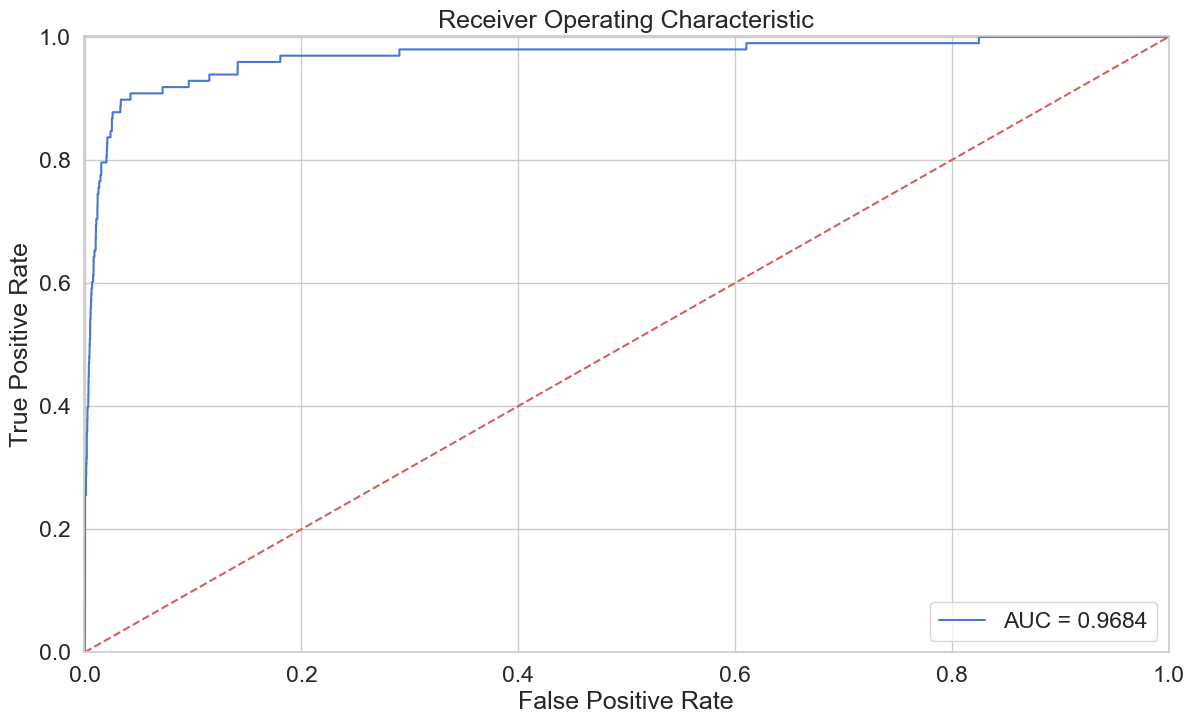

Card Precision at k=100: 0.28


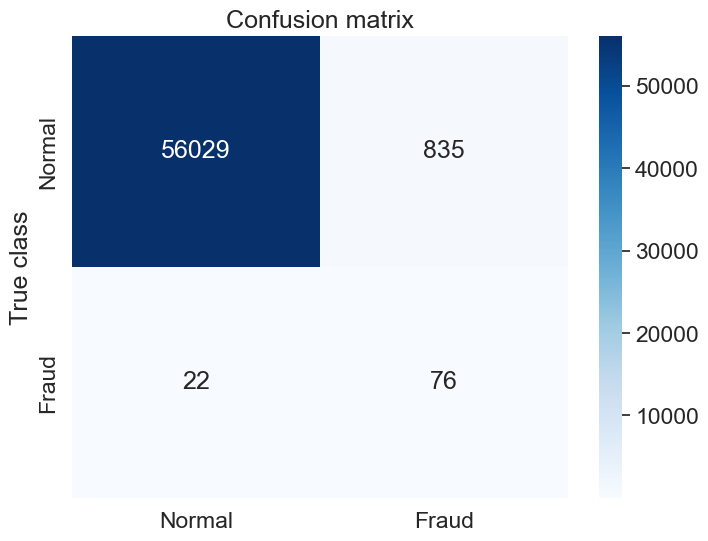

In [3]:
class GEU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 1个可学习参数 sigma

    def forward(self, input):
        # 计算 GEU 激活函数的输出
        temp = torch.tanh(input / self.sigma)
        return temp

class SiLU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 1个可学习参数 sigma

    def forward(self, input):
        # GELU 激活函数的计算公式
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input /self.sigma)
        temp = torch.where(input >= 0, input, input * torch.exp(-input**2 / (2 * self.sigma**2)))
        return temp

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29,14),
            GEU(),
            nn.Linear(14,7),
            SiLU(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 7),
            GEU(),
            nn.Linear(7, 29),
            SiLU()
            )
    def forward(self , x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

model = Autoencoder().double().cpu()
num_epochs = 100
minibach_size = 32
lr = 1e-3
train_loader = data_utils.DataLoader(X_train,batch_size=minibach_size,shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=lr, weight_decay=10e-05)
history = {}
history['train_loss'] = []
history['test_loss'] = []
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)

pred_losses = { 'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

threshold = 2.9
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]

conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap='Blues')  # Use 'Blues' directly
plt.title("Confusion matrix")
plt.ylabel('True class')
from sklearn.metrics import precision_score, roc_curve, auc
def card_precision_at_k(pred_scores, true_labels, k=100):
    # Sort predictions by scores in descending order
    sorted_indices = np.argsort(pred_scores)[::-1]
    # Get top k indices
    top_k_indices = sorted_indices[:k]
    # Get corresponding true labels
    top_k_labels = true_labels[top_k_indices]
    # Calculate precision for top k
    precision = precision_score(top_k_labels, np.ones(k))  # assuming 1 is the positive class
    return precision
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

# Calculate card precision at k
pred_scores = reconstructionErrorDF['pred_loss'].values
k = 100
card_precision = card_precision_at_k(pred_scores, y_test, k=k)
print(f"Card Precision at k={k}: {card_precision}")

epoch [1/100], loss:0.6398
epoch [2/100], loss:0.5542
epoch [3/100], loss:0.5416
epoch [4/100], loss:0.5363
epoch [5/100], loss:0.5339
epoch [6/100], loss:0.5329
epoch [7/100], loss:0.5321
epoch [8/100], loss:0.5316
epoch [9/100], loss:0.5307
epoch [10/100], loss:0.5272
epoch [11/100], loss:0.5254
epoch [12/100], loss:0.5244
epoch [13/100], loss:0.5239
epoch [14/100], loss:0.5234
epoch [15/100], loss:0.5232
epoch [16/100], loss:0.5231
epoch [17/100], loss:0.5230
epoch [18/100], loss:0.5227
epoch [19/100], loss:0.5226
epoch [20/100], loss:0.5224
epoch [21/100], loss:0.5226
epoch [22/100], loss:0.5223
epoch [23/100], loss:0.5222
epoch [24/100], loss:0.5221
epoch [25/100], loss:0.5220
epoch [26/100], loss:0.5220
epoch [27/100], loss:0.5220
epoch [28/100], loss:0.5220
epoch [29/100], loss:0.5219
epoch [30/100], loss:0.5218
epoch [31/100], loss:0.5219
epoch [32/100], loss:0.5218
epoch [33/100], loss:0.5219
epoch [34/100], loss:0.5217
epoch [35/100], loss:0.5218
epoch [36/100], loss:0.5217
e

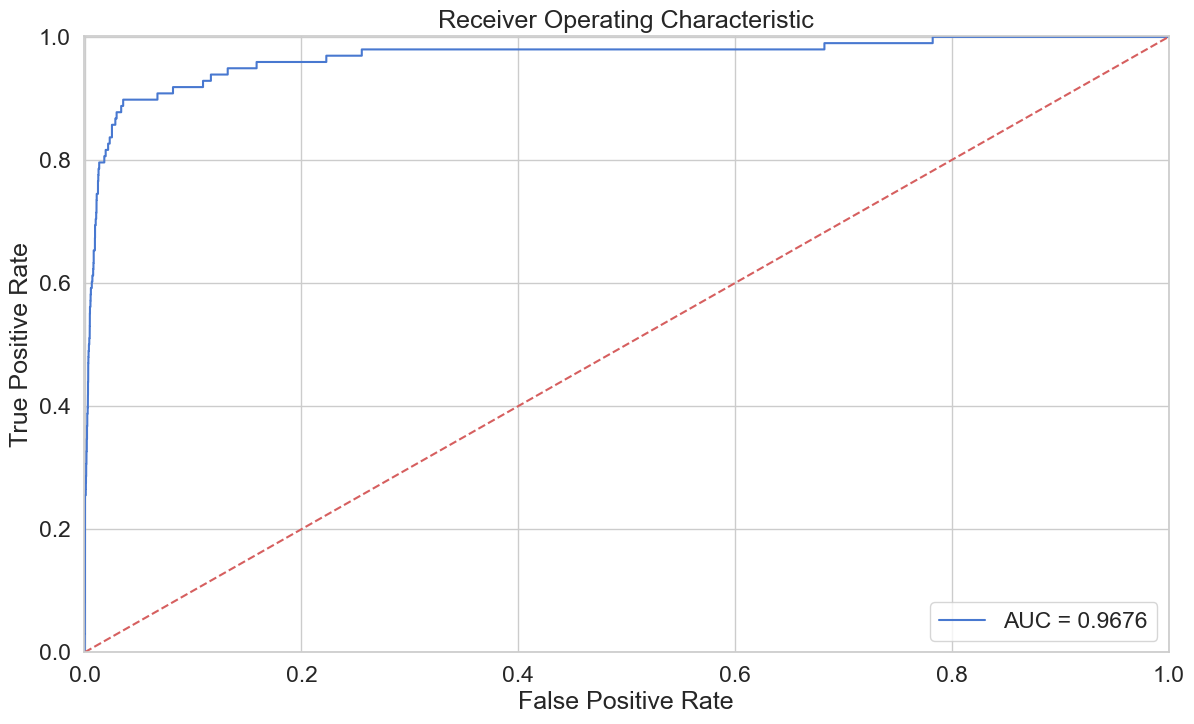

Card Precision at k=100: 0.28


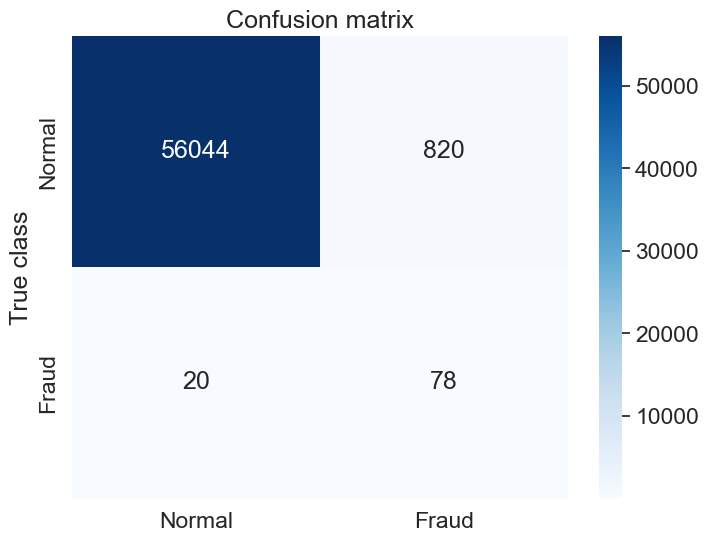

In [4]:
class GEU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 1个可学习参数 sigma

    def forward(self, input):
        # 计算 GEU 激活函数的输出
        temp = torch.tanh(input / self.sigma)
        return temp

class SiLU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(0.5))  # 1个可学习参数 sigma

    def forward(self, input):
        # GELU 激活函数的计算公式
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        #temp = input * torch.sigmoid(input /self.sigma)
        temp = torch.where(input >= 0, input, input * torch.exp(-input**2 / (2 * self.sigma**2)))
        return temp

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29,14),
            GEU(),
            nn.Linear(14,7),
            SiLU(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(7, 7),
            GEU(),
            nn.Linear(7, 29),
            SiLU()
            )
    def forward(self , x):
        x = self.encoder(x)
        x = self.decoder(x)
        return(x)

model = Autoencoder().double().cpu()
num_epochs = 100
minibach_size = 32
lr = 1e-3
train_loader = data_utils.DataLoader(X_train,batch_size=minibach_size,shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=lr, weight_decay=10e-05)
history = {}
history['train_loss'] = []
history['test_loss'] = []
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)

pred_losses = { 'pred_loss' : []}
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs = data
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        pred_losses['pred_loss'].append(loss)
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

threshold = 2.9
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]

conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap='Blues')  # Use 'Blues' directly
plt.title("Confusion matrix")
plt.ylabel('True class')
from sklearn.metrics import precision_score, roc_curve, auc
def card_precision_at_k(pred_scores, true_labels, k=100):
    # Sort predictions by scores in descending order
    sorted_indices = np.argsort(pred_scores)[::-1]
    # Get top k indices
    top_k_indices = sorted_indices[:k]
    # Get corresponding true labels
    top_k_labels = true_labels[top_k_indices]
    # Calculate precision for top k
    precision = precision_score(top_k_labels, np.ones(k))  # assuming 1 is the positive class
    return precision
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

# Calculate card precision at k
pred_scores = reconstructionErrorDF['pred_loss'].values
k = 100
card_precision = card_precision_at_k(pred_scores, y_test, k=k)
print(f"Card Precision at k={k}: {card_precision}")